# Measurement

We support the following measurements:

- spectroscopy
- lifetime
- Rabi oscillation

In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pydatatom import *

%matplotlib ipympl

## Spectroscopy

Here we analyze two datasets where we scan the resonance of

- the clock transition $\ket{1{}^1S_0}\to\ket{1{}^3P_0}$, and
- the rydberg transition $\ket{1{}^3P_0}\to\ket{53.3{}^1S_0}$

In [2]:
raw_dataset_clk = GzipPickleDataset("/tmp/data/2025-08-05_AA")
raw_dataset_ryd = GzipPickleDataset("/tmp/data/2025-08-05_AO")

prob_pipeline_spec = Pipeline('probability', steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline_spec.fit(raw_dataset_clk)

clk_df = prob_pipeline_spec.dataframe(raw_dataset_clk)
ryd_df = prob_pipeline_spec.dataframe(raw_dataset_ryd)

In [3]:
clk_df['df_clock_fundamental'] = clk_df['f_clock_fundamental_large_sideband'] - 2*clk_df['df_yellow_AOM']
clk_df.head()

,run,TC_systime_sec,df_yellow_AOM,f_clock_fundamental_large_sideband,probability,df_clock_fundamental
0,11260.0,8.714378e+13,0.001050,196.116356,0.692308,196.114256
3,12366.0,8.798405e+13,0.000875,196.116386,0.818182,196.114636
4,11200.0,8.709818e+13,-0.002275,196.116355,1.000000,196.120905
5,697.0,8.890266e+13,-0.003500,196.116418,0.916667,196.123418
6,11309.0,8.718091e+13,0.002450,196.116358,0.857143,196.111458


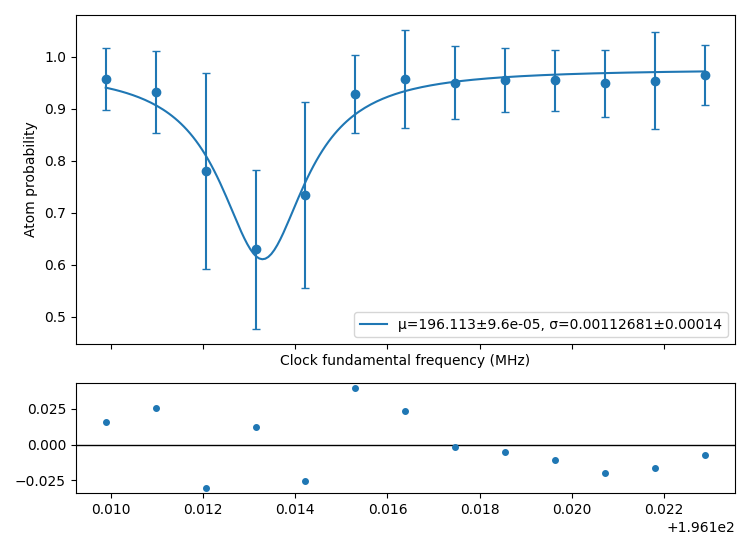

In [4]:
x, y, yerr = aggregate(clk_df['df_clock_fundamental'].to_numpy(), clk_df['probability'].to_numpy())

fig, (ax, axr) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(7.5, 5.5))

plot_resonance(x, y, yerr, fit_resonance(x, y), ax, axr)

ax.set_ylabel('Atom probability')
ax.set_xlabel('Clock fundamental frequency (MHz)')
ax.legend()

plt.tight_layout()
plt.show()

In [5]:
ryd_df.head()

,run,TC_systime_sec,f_clock_fundamental_large_sideband,f_rydberg_beatlock,probability
0,525.0,1.124568e+14,196.116454,78.15,0.666667
1,1868.0,1.135112e+14,196.116491,76.40,0.727273
2,1771.0,1.134361e+14,196.116488,76.65,0.750000
3,1631.0,1.133279e+14,196.116485,78.40,0.750000
4,465.0,1.124104e+14,196.116453,80.90,0.500000


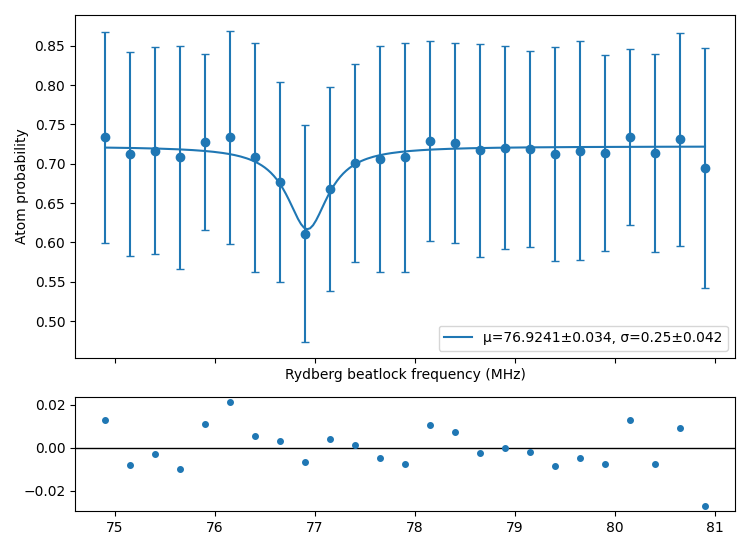

In [6]:
x, y, yerr = aggregate(ryd_df['f_rydberg_beatlock'].to_numpy(), ryd_df['probability'].to_numpy())

fig, (ax, axr) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(7.5, 5.5))

plot_resonance(x, y, yerr, fit_resonance(x, y), ax, axr)

ax.set_ylabel('Atom probability')
ax.set_xlabel('Rydberg beatlock frequency (MHz)')
ax.legend()

plt.tight_layout()
plt.show()

## Overnight spectroscopy

Here we scan the $\ket{{}^1S_0}\to\ket{{}^3P_0}$ "clock" transition over night, i.e., for many hours, to see it drift.

In [7]:
# todo

## Lifetime

Here we optimize the fluorescence imaging parameters using the $\ket{{}^1S_0}\to\ket{{}^1P_1}$ such that the loss rate is minimized.

In [8]:
raw_dataset_lft = GzipPickleDataset("/tmp/data/2025-07-25_AR")
len(raw_dataset_lft)

285

In [9]:
count_pipeline_lft = Pipeline('count', steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    # for this dataset, we have no first image to correct for probabilistic loading
    # instead we just sum over the detected atoms to count the atoms
    TransformStep(lambda x: x.sum())
])
count_pipeline_lft.fit(raw_dataset_lft)

In [10]:
lft_df = count_pipeline_lft.dataframe(raw_dataset_lft)
lft_df.head()

,run,TC_systime_sec,df_green_cooling_bluegreen_imaging,blue_green_imaging_duration,count
0,10.0,2.906037e+14,-12.10,0.10,12
1,18.0,2.906152e+14,-12.10,0.35,11
2,171.0,2.908350e+14,-12.15,0.01,0
3,47.0,2.906568e+14,-12.15,0.35,12
4,142.0,2.907934e+14,-12.10,0.01,0


In [11]:
lft_df["df_green_cooling_bluegreen_imaging"].unique()

array([-12.1 , -12.15, -12.05, -12.  ])

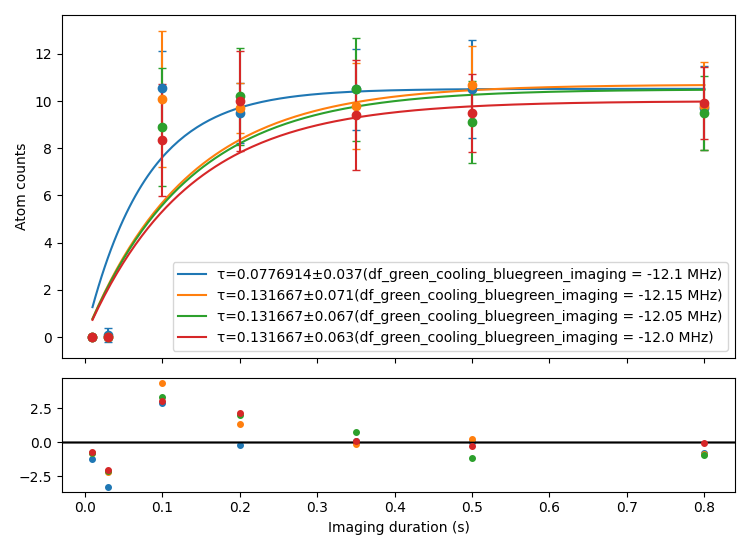

In [12]:
fig, (ax, axr) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(7.5, 5.5))

for df_green in lft_df["df_green_cooling_bluegreen_imaging"].unique():
    df = lft_df[lft_df["df_green_cooling_bluegreen_imaging"] == df_green]

    x, y, yerr = aggregate(df["blue_green_imaging_duration"], df["count"])
    model = fit_lifetime(x, y)
    
    plot_lifetime(x, y, yerr, model, ax, axr, label=f"df_green_cooling_bluegreen_imaging = {df_green} MHz")

ax.legend()
ax.set_ylabel('Atom counts')
axr.set_xlabel('Imaging duration (s)')

plt.tight_layout()
plt.show()

## Rabi oscillations

Here we analyze two datasets where we scan the duration of pulse driving

- the clock transition $\ket{1{}^1S_0}\to\ket{1{}^3P_0}$, and
- the rydberg transition $\ket{1{}^3P_0}\to\ket{53.3{}^1S_0}$

In [13]:
raw_dataset_rabclk = GzipPickleDataset("/tmp/data/2025-08-11_AH")
raw_dataset_rabryd = GzipPickleDataset("/tmp/data/2025-08-11_AR")

In [14]:
prob_pipeline_rab = Pipeline('probability', steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline_rab.fit(raw_dataset_rabclk)

In [15]:
rabclk_df = prob_pipeline_rab.dataframe(raw_dataset_rabclk)
rabclk_df.head()

,run,TC_systime_sec,dt_clock_duration,f_clock_fundamental_large_sideband,probability
0,522.0,1.144137e+13,0.000004,196.134612,1.000000
1,1865.0,1.244422e+13,0.000011,196.134646,0.416667
2,1768.0,1.237180e+13,0.000017,196.134644,0.230769
3,1628.0,1.226729e+13,0.000017,196.134640,0.416667
4,462.0,1.139655e+13,0.000004,196.134610,0.846154


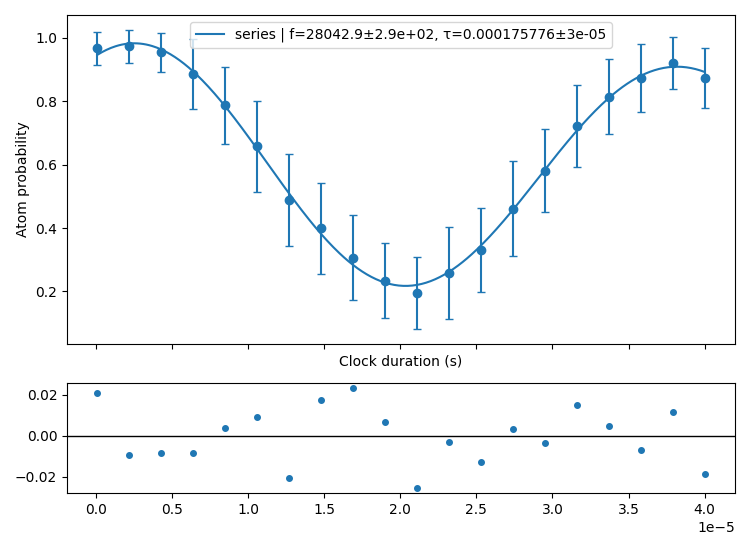

In [16]:
x, y, yerr = aggregate(rabclk_df['dt_clock_duration'].to_numpy(), rabclk_df['probability'].to_numpy())

fig, (ax, axr) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(7.5, 5.5))

plot_rabiosc(x, y, yerr, fit_rabiosc(x, y), ax, axr)

ax.set_ylabel('Atom probability')
ax.set_xlabel('Clock duration (s)')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
rabryd_df = prob_pipeline_rab.dataframe(raw_dataset_rabryd)
rabryd_df.head()

,run,TC_systime_sec,f_clock_fundamental_large_sideband,dt_rydberg_ionization,probability
23,834.0,1.689911e+13,196.134801,3.740000e-06,0.0
43,93.0,1.632123e+13,196.134781,1.000000e-07,0.0
44,1039.0,1.705842e+13,196.134807,2.180000e-06,1.0
61,694.0,1.679044e+13,196.134798,1.660000e-06,0.0
62,997.0,1.702581e+13,196.134806,7.500000e-07,0.0


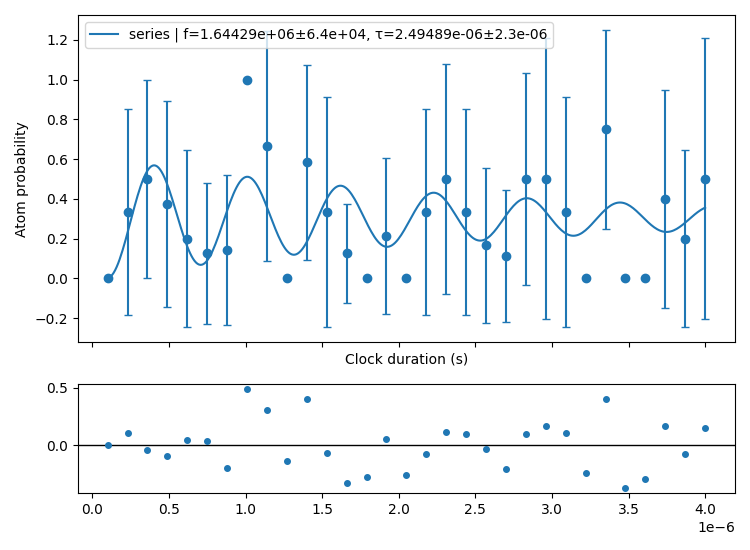

In [18]:
x, y, yerr = aggregate(rabryd_df['dt_rydberg_ionization'].to_numpy(), rabryd_df['probability'].to_numpy())

fig, (ax, axr) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(7.5, 5.5))

plot_rabiosc(x, y, yerr, fit_rabiosc(x, y), ax, axr)

ax.set_ylabel('Atom probability')
ax.set_xlabel('Clock duration (s)')
ax.legend()

plt.tight_layout()
plt.show()